# NYU - ML4C
## Brief
This notebook 
- imports the shapefile
- imports census data
- merges shapefiles with census data
- map median rent
- outputs a .csv of the results
- You can refer to https://github.com/mv1742/ML4C

In [265]:
#! pip install geopandas
#import all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
%pylab inline
import sklearn.metrics as skl
# To ignore some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import requests
import shapely
import json
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
#from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
#pd.options.display.max_columns = None
DEVELOPING = False
#from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
#from evalChisq import evalChisqgeoid

from urllib.error import HTTPError
import urllib.request as request
try:
    from urllib import urlretrieve as urlretrieve
except ImportError:
    from urllib.request import urlretrieve as urlretrieve

Populating the interactive namespace from numpy and matplotlib


In [107]:
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas import GeoDataFrame
from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [108]:
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score

# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
import pandas as pd
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
import pandas as pd
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [109]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/ML4C/Project".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /nfshome/mv1742/ML4C/Project


In [110]:
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('Master')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)

# Import Shape Files
#### Retrieved from latest Census 2016 results from NYC Planning Metro Region Explorer:
https://metroexplorer.planning.nyc.gov/about

and four missing census tracts from census.gov American Fact Finder: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml


In [111]:
# # Greater NYC:::

# url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
# NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
# # NYCzip=gpd.read_file('Censustracts/region.shp')

In [112]:
# NYC ONLY (5 boroughs/counties)
NYCzip=gpd.read_file('Data/14000.shp')
# NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
# NYCzip.GEOID = NYCzip.GEOID.astype(int)
# cols = ['GEOID','geometry']
# NYCzip = NYCzip.loc[:,cols]
# #NYCzipgdp.plot(column='GEOID',legend = True)
# NYCzip.shape
# NYCzip.isnull().sum()
# figure, ax = plt.subplots(figsize=(15, 15))
# NYCzip.plot(column='GEOID',legend = True, ax=ax)

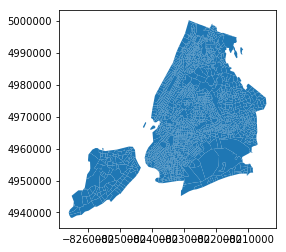

In [113]:
NYCzip.plot()

In [114]:
NYCzip.columns

Index(['GEO_ID', 'STATE', 'COUNTY', 'TRACT', 'NAME', 'LSAD', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')

In [115]:
NYCzip.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,SHAPE_AREA,SHAPE_LEN,geometry
0,1400000US36061023200,36,061,023200,232,Tract,3.154541e+05,2319.596620,"POLYGON ((-8231231.5405 4986146.175700001, -82..."
1,1400000US36061023501,36,061,023501,235.01,Tract,3.139373e+05,2227.424896,POLYGON ((-8231450.728599999 4987247.602399997...
2,1400000US36061023802,36,061,023802,238.02,Tract,9.797173e+05,4801.298923,"POLYGON ((-8232073.2272 4977541.762199998, -82..."
3,1400000US36061024000,36,061,024000,240,Tract,5.272424e+06,10203.779513,"POLYGON ((-8230544.476600001 4980781.7531, -82..."
4,1400000US36005042200,36,005,042200,422,Tract,3.055759e+05,2249.832422,POLYGON ((-8221892.614499999 4996327.083999999...


In [116]:
NYCzip.rename(columns={"GEO_ID": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(str).str[-11:]
NYCzip.GEOID = NYCzip.GEOID.astype(int)

In [117]:
NYCzip.isnull().sum()

GEOID         0
STATE         0
COUNTY        0
TRACT         0
NAME          0
LSAD          0
SHAPE_AREA    0
SHAPE_LEN     0
geometry      0
dtype: int64

In [118]:
# NYCzipgdp.dropna(inplace=True)
NYCzip.shape

(2166, 9)

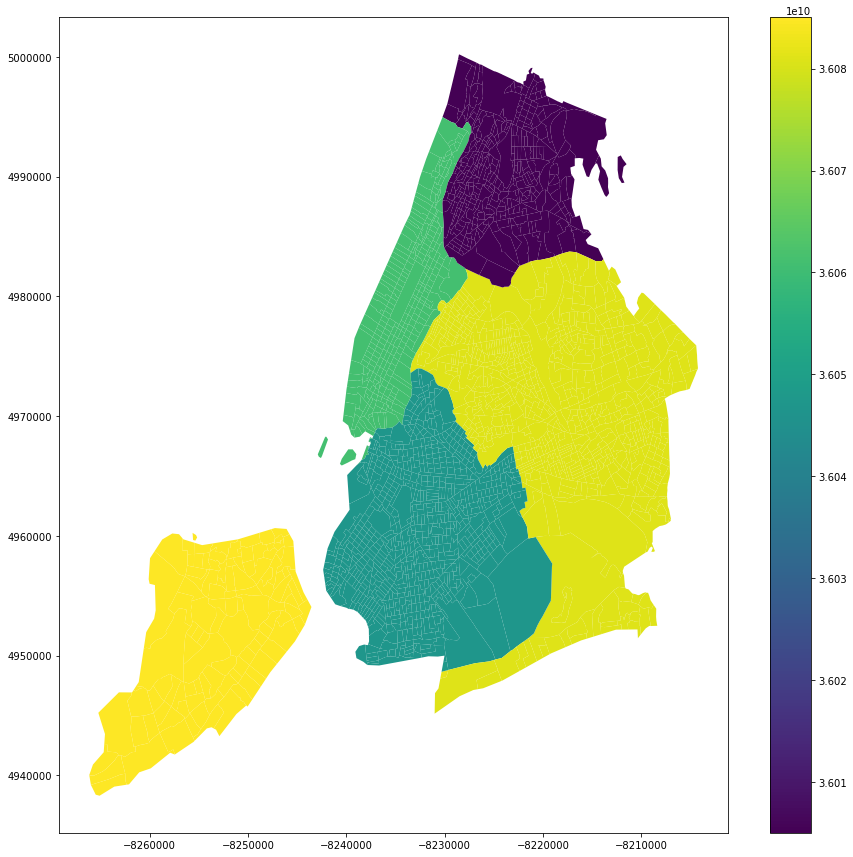

In [119]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

In [120]:
cols = ['GEOID']
NYCzip[cols].head()

,GEOID
0,36061023200
1,36061023501
2,36061023802
3,36061024000
4,36005042200


In [121]:
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape

(2166, 1)

In [122]:
NYCzip.head(2)

,GEOID
0,36061023200
1,36061023501


In [123]:
# Greater NYC
NYzip_url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
NYzip = getGeoDataFrameFromShpFileZipUrl(NYzip_url)

In [124]:
NYzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYzip.GEOID = NYzip.GEOID.astype(int)
cols = ['GEOID','geometry']

NYCzipgdp = NYzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzipgdp.shape


(5294, 2)

In [125]:
NYCzipgdp = NYCzipgdp.merge(NYCzip,on='GEOID')
NYCzipgdp.tail()

,GEOID,geometry
2159,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...
2160,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,..."
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,..."


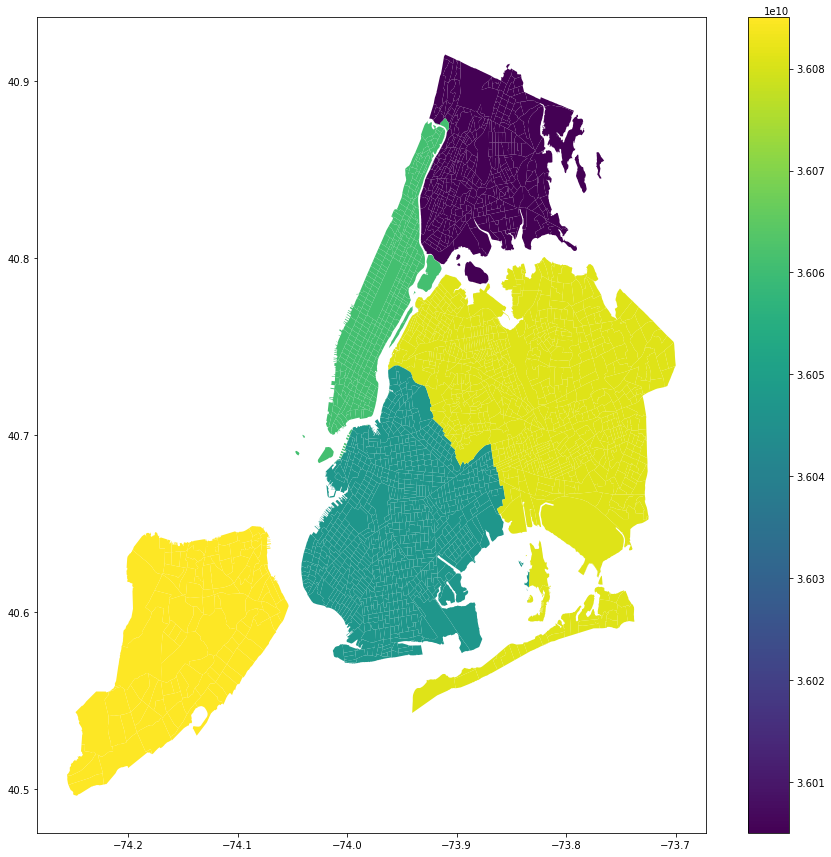

In [126]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzipgdp.plot(column='GEOID',legend = True, ax=ax)

# Import Latest Census Data

In [127]:
Censuspd = pd.read_stata('Data/UDP_NYC_Variables.dta')
Censuspdgdp = gpd.GeoDataFrame(Censuspd)
Censuspdgdp.columns

Index(['GEOid2', 'hh16', 'moe_hh16', 'per_col00', 'per_nonwhite00',
       'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000',
       'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'per_nonwhite90',
       'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990',
       'vhi1990', 'denominator', 'per_all_li90', 'all_li_count90', 'pop00',
       'pop16', 'moe_pop16', 'ch_all_li_count90_00', 'ch_all_li_count00_16',
       'moveinincd16', 'co_med_indinc16', 'per_limove16', 'per_limove09',
       'TOD', 'empd15', 'mrent90', 'rou90', 'mrent00', 'rou00', 'mrent16',
       'moe_mrent16', 'mhval90', 'ohu90', 'mhval00', 'ohu00', 'mhval16',
       'moe_mhval16', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16',
       'hu16', 'per_units_pre50', 'ohu16', 'moe_owner16', 'rhu16',
       'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016',
       'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16',
       'all_li_count16', 'ag25up', 'bachelors',

In [128]:
Censuspdgdp.rename(columns={'GEOid2': "GEOID"},inplace=True)
Censuspdgdp.tail(2)

,GEOID,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
5336,36119984000,92.0,37.0,0.121495,0.517544,0.0,0.220431,0.394953,-1.490116e-08,0.019975,...,749.0,0.255689,48.0,38929.0,16474.0,-54.0,46444.95,55472.790653,-0.162744,-0.161825
5337,36119985000,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# cols_typ = ['GEOID','medrent16']
print(type(Censuspdgdp.iloc[:,0][0]))
# Censuspdgdp = Censuspdgdp.loc[:,cols_typ]
Censuspd.head()

<class 'str'>


,GEOid2,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
0,09001010101,1348.0,106.0,0.633120,0.066080,0.128119,0.097024,0.082058,0.058617,0.036841,...,4277.000000,0.516292,84.0,150655.0,21659.0,-529.0,273976.05,173204.009350,0.581811,-0.450116
1,09001010102,1293.0,100.0,0.748477,0.098972,0.108108,0.097878,0.055028,0.057780,0.040756,...,4273.694824,0.619490,71.0,250000.0,NaN,-302.0,290000.00,274501.826719,0.056459,-0.137931
2,09001010201,991.0,75.0,0.704225,0.088501,0.137864,0.055506,0.036763,0.027295,0.033678,...,3156.218236,0.602177,53.0,212448.0,58671.0,-158.0,290000.00,273595.114640,0.059960,-0.267421
3,09001010202,1856.0,99.0,0.621305,0.130701,0.213789,0.127129,0.112302,0.072605,0.062817,...,4725.289978,0.597040,82.0,187875.0,31078.0,328.0,157543.95,157618.518565,-0.000473,0.192524
4,09001010300,1435.0,111.0,0.716889,0.103641,0.273834,0.095201,0.074789,0.058684,0.052763,...,4036.000000,0.647751,85.0,221250.0,44939.0,-71.0,246540.60,186207.991984,0.324007,-0.102582


In [130]:
Censuspdgdp.shape

(5338, 89)

In [131]:
# Censuspdgdp.dropna(inplace=True)

## Clean Data

In [132]:
Censuspdgdp.isnull().sum()

GEOID                     0
hh16                     33
moe_hh16                 33
per_col00                82
per_nonwhite00           81
per_rent00               89
vli2000                  92
li2000                   92
mi2000                   92
hmi2000                  92
hi2000                   92
vhi2000                  92
per_all_li00             92
hh00                     61
all_li_count00           92
per_nonwhite90           68
per_rent90               77
vli1990                  77
li1990                   77
mi1990                   77
hmi1990                  77
hi1990                   77
vhi1990                  77
denominator              61
per_all_li90             77
all_li_count90           77
pop00                    61
pop16                    33
moe_pop16                33
ch_all_li_count90_00     94
                       ... 
per_rent16              104
per_nonwhite16           86
vli2016                 104
li2016                  104
mi2016              

In [133]:
# counter = 0
# for column in Censuspdgdp.columns:
#     if column not in df_Variables.columns:
#         counter += 1
#         print(column)

In [134]:
print(len(Censuspdgdp.GEOID.unique()))
# Censuspdgdp.dropna(inplace=True)
Censuspdgdp.shape

5338


(5338, 89)

In [135]:
Censuspdgdp =Censuspdgdp.drop_duplicates()
Censuspdgdp.shape

(5338, 89)

In [136]:
# print(NYCzipgdp.shape)
# Censuspdgdp.rename(columns={'geoid': "GEOID"},inplace=True)
Censuspdgdp[Censuspdgdp.GEOID==36047021000]

,GEOID,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16


In [137]:
Censuspdgdp.replace('Nan',np.NaN, inplace = True)

In [138]:
for column in Censuspdgdp.columns:
    Censuspdgdp[column] = pd.to_numeric(Censuspdgdp[column].values, errors='coerce')

In [139]:
len(Censuspdgdp.mhval16.isnull())

5338

In [140]:
type(Censuspdgdp.GEOID[5297])

numpy.int64

In [141]:
Censuspdgdp.shape
Censuspdgdp.dropna(inplace=True,how='all')
Censuspdgdp.shape

(5338, 89)

### MERGE

In [142]:
merged = NYCzipgdp.merge(Censuspdgdp,on='GEOID')
merged.tail()

,GEOID,geometry,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
2159,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,4.0,6.0,0.134557,0.989928,1.000000,0.481906,0.208198,0.064489,...,0.854182,0.000095,6.0,NaN,NaN,7.006433,34971.10032,26333.700869,0.327998,NaN
2160,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,2876.0,150.0,0.152688,0.983061,0.942688,0.513238,0.179940,0.076447,...,4258.000000,0.075093,74.0,48429.0,6061.0,2092.000000,32256.70000,16680.450280,0.933803,0.501363
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",2083.0,115.0,0.057858,0.976335,0.988011,0.621887,0.177527,0.049810,...,5085.000000,0.055690,81.0,21585.0,5374.0,-8.000000,25044.40000,25103.939512,-0.002372,-0.138131
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,1117.0,97.0,0.282637,0.974572,0.827789,0.439632,0.187200,0.079572,...,1408.000000,0.161512,69.0,41635.0,13171.0,288.000000,43768.25000,35593.500000,0.229670,-0.048740
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",1064.0,59.0,0.422212,0.660112,0.521779,0.129393,0.100985,0.064595,...,3171.000000,1.036555,49.0,85147.0,22920.0,89.000000,84499.12500,98343.495042,-0.140776,0.007667


In [143]:
print(type(merged),merged.shape)
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

<class 'geopandas.geodataframe.GeoDataFrame'> (2164, 90)


(2164, 90)

In [144]:
mergedgpd.isnull().sum()

GEOID                 0
geometry              0
hh16                  0
moe_hh16              0
per_col00            33
per_nonwhite00       32
per_rent00           39
vli2000              39
li2000               39
mi2000               39
hmi2000              39
hi2000               39
vhi2000              39
per_all_li00         39
hh00                 12
all_li_count00       39
per_nonwhite90       19
per_rent90           26
vli1990              26
li1990               26
mi1990               26
hmi1990              26
hi1990               26
vhi1990              26
denominator          12
per_all_li90         26
all_li_count90       26
pop00                12
pop16                 0
moe_pop16             0
                     ..
per_rent16           44
per_nonwhite16       36
vli2016              44
li2016               44
mi2016               44
hmi2016              44
hi2016               44
vhi2016              44
per_all_li16         44
all_li_count16       44
ag25up          

In [145]:
print(len(Censuspdgdp.GEOID),len(mergedgpd.GEOID))
print(type(Censuspdgdp.GEOID),type(mergedgpd.GEOID))
 

5338 2164
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [146]:
# excluded = []
# for i in Censuspdgdp.GEOID:
#     if i not in list(mergedgpd.GEOID):
#         print('i',i)
#         excluded.append(i)
# excluded

In [147]:
(NYCzip.GEOID == 36061022102).sum()

1

In [148]:
# mergedgpd.crs = from_epsg(4326)
# mergedgpd.crs

In [149]:
# mergedgpd.to_crs(epsg=2263, inplace = True)
# mergedgpd.crs

In [150]:
len(mergedgpd.mhval16)

2164

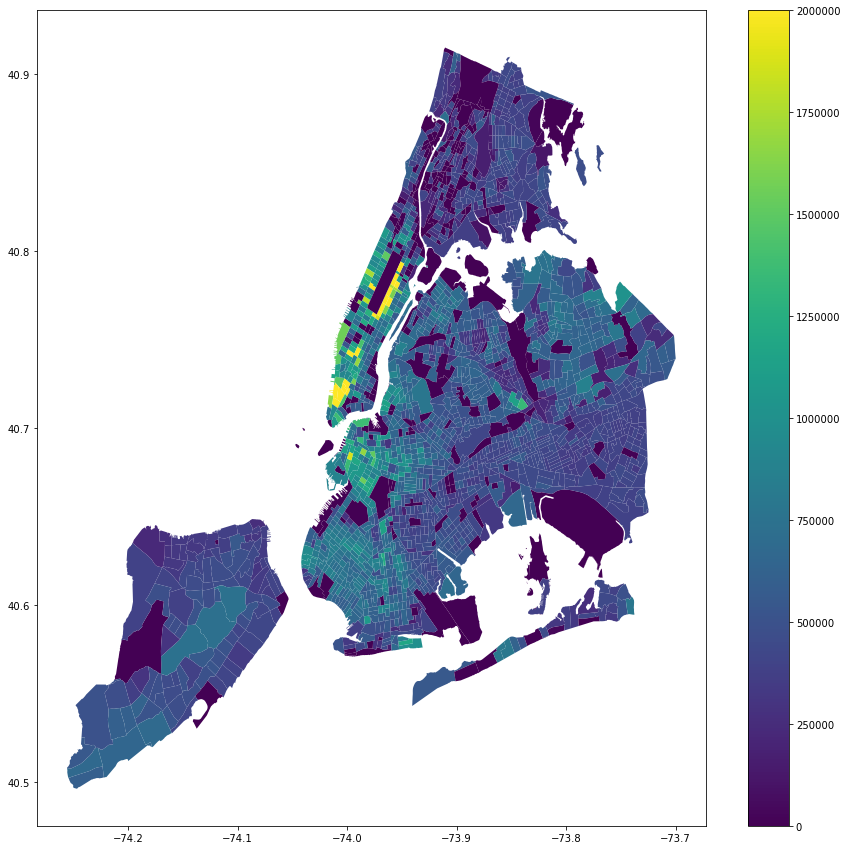

In [151]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='mhval16',legend = True, ax=ax)

# Part 2. Explore the Data

### Covariance Matrix

In [152]:
mergedgpd.shape

(2164, 90)

In [153]:
corrmatrix_Pearson = mergedgpd.corr()
Pearson = corrmatrix_Pearson.iloc[0][1]
Cov_medhval16_medrent90 = cov(mergedgpd.mhval16,mergedgpd.mrent90)
print(corrmatrix_Pearson.shape)
print('Pearson product-moment correlation coefficient (PPMCC) :',Pearson)
print('Covariance is:', Cov_medhval16_medrent90[0][1])

(89, 89)
Pearson product-moment correlation coefficient (PPMCC) : -0.0239029384958
Covariance is: nan


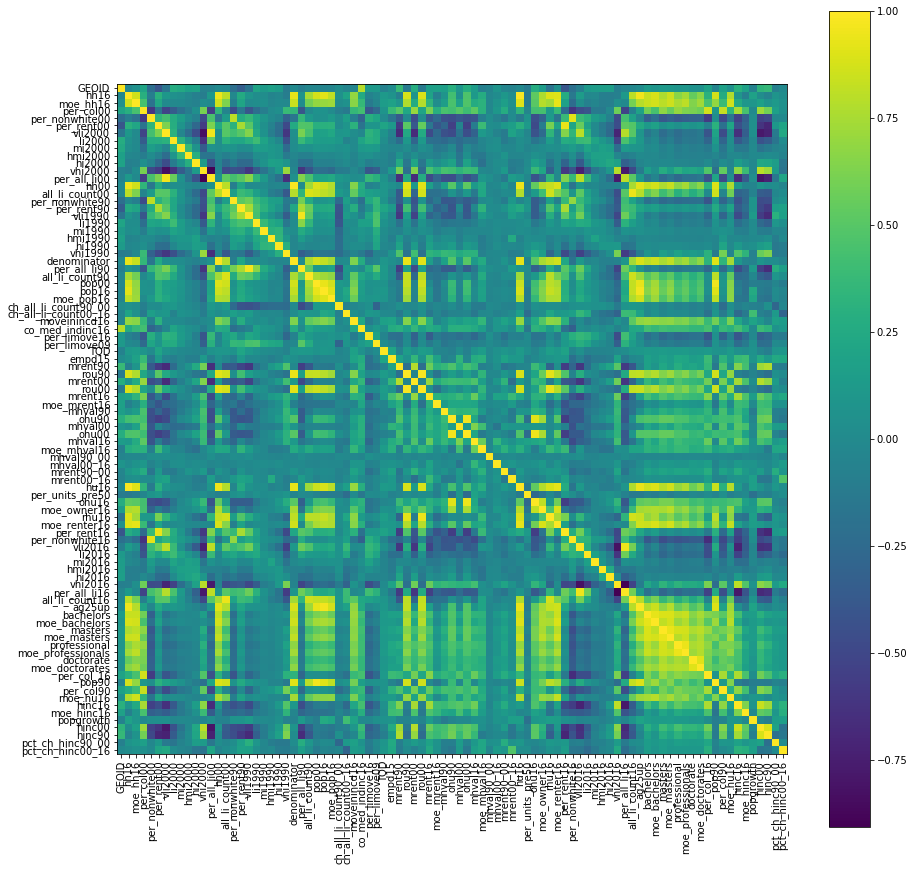

In [154]:
ax = plt.figure(figsize=(15,15)).add_subplot(111)
cax = ax.imshow(corrmatrix_Pearson, cmap='viridis')
plt.colorbar(cax)
ax.set_xticks(range(len(corrmatrix_Pearson.columns)))
ax.set_xticklabels(corrmatrix_Pearson.columns, rotation=90)
ax.set_yticks(range(len(corrmatrix_Pearson.columns)))
ax.set_yticklabels(corrmatrix_Pearson.columns);

In [155]:
# corrmatrix_Pearson['medhval16']
corrmatrix_Pearson.iloc[20:40]

,GEOID,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
hmi1990,0.175104,-0.048810,-0.031416,0.010050,0.008235,-0.061769,-0.092957,0.074347,0.104448,0.099927,...,-0.038691,0.106282,-0.019212,0.001102,-0.034129,0.000719,0.009021,0.039542,-0.099482,-0.007503
hi1990,0.141591,-0.025779,0.002143,0.045218,-0.046027,-0.209122,-0.214619,-0.022063,0.075063,0.071145,...,-0.042279,0.208754,-0.007287,0.122592,0.025445,0.054166,0.138990,0.185484,-0.133489,-0.096914
vhi1990,-0.109645,-0.099147,-0.013718,0.387345,-0.310489,-0.489161,-0.598409,-0.440149,-0.232112,-0.116043,...,-0.130142,0.601630,-0.045418,0.481423,0.336116,-0.070391,0.557655,0.627820,-0.136706,-0.105035
denominator,-0.001285,0.930782,0.839818,0.355526,-0.158455,0.260790,0.046668,0.030363,0.022529,-0.032616,...,0.904218,0.341256,0.746375,0.101517,-0.040540,-0.060060,0.080848,0.019468,0.022233,-0.035798
per_all_li90,-0.083015,0.082447,0.018155,-0.399462,0.366311,0.480302,0.615916,0.374705,0.071055,-0.076247,...,0.119821,-0.244651,0.044178,-0.453558,-0.273821,0.116807,-0.545614,-0.662015,0.280886,0.159493
all_li_count90,-0.033553,0.741230,0.592539,-0.007070,0.122412,0.471975,0.435108,0.253024,0.056773,-0.078702,...,0.804881,0.072700,0.545826,-0.234686,-0.213094,-0.021794,-0.291159,-0.374782,0.097170,0.033295
pop00,-0.028769,0.874613,0.691475,0.068773,0.047006,0.297724,0.177349,0.159603,0.094512,-0.005226,...,0.966633,0.096963,0.657430,-0.113126,-0.185173,-0.089224,-0.099119,-0.115040,-0.040321,-0.102663
pop16,-0.047957,0.913598,0.705297,0.066389,0.057687,0.303550,0.186919,0.148685,0.087457,-0.006461,...,0.903768,0.078903,0.672003,-0.080635,-0.184920,0.258286,-0.105110,-0.143438,0.013717,-0.039099
moe_pop16,-0.039577,0.816633,0.718182,0.016740,0.113991,0.320487,0.228187,0.157084,0.083773,-0.019156,...,0.819090,0.039875,0.678719,-0.143289,-0.167086,0.211304,-0.147768,-0.178922,0.004484,-0.056193
ch_all_li_count90_00,0.027206,0.060002,0.027326,-0.082028,0.031109,0.020930,0.090002,0.106501,0.048588,0.011904,...,0.039998,-0.222416,0.033157,-0.084947,-0.039274,-0.068610,-0.081439,0.051891,-0.266364,-0.029027


In [156]:
len(mergedgpd.columns)

90

In [157]:
# income related variables
# housing price related variables

Index(['GEOID', 'hh16', 'moe_hh16', 'per_col00', 'per_nonwhite00',
       'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000',
       'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'per_nonwhite90',
       'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990',
       'vhi1990', 'denominator', 'per_all_li90', 'all_li_count90', 'pop00',
       'pop16', 'moe_pop16', 'ch_all_li_count90_00', 'ch_all_li_count00_16',
       'moveinincd16', 'co_med_indinc16', 'per_limove16', 'per_limove09',
       'TOD', 'empd15', 'mrent90', 'rou90', 'mrent00', 'rou00', 'mrent16',
       'moe_mrent16', 'mhval90', 'ohu90', 'mhval00', 'ohu00', 'mhval16',
       'moe_mhval16', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16',
       'hu16', 'per_units_pre50', 'ohu16', 'moe_owner16', 'rhu16',
       'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016',
       'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16',
       'all_li_count16', 'ag25up', 'bachelors', 

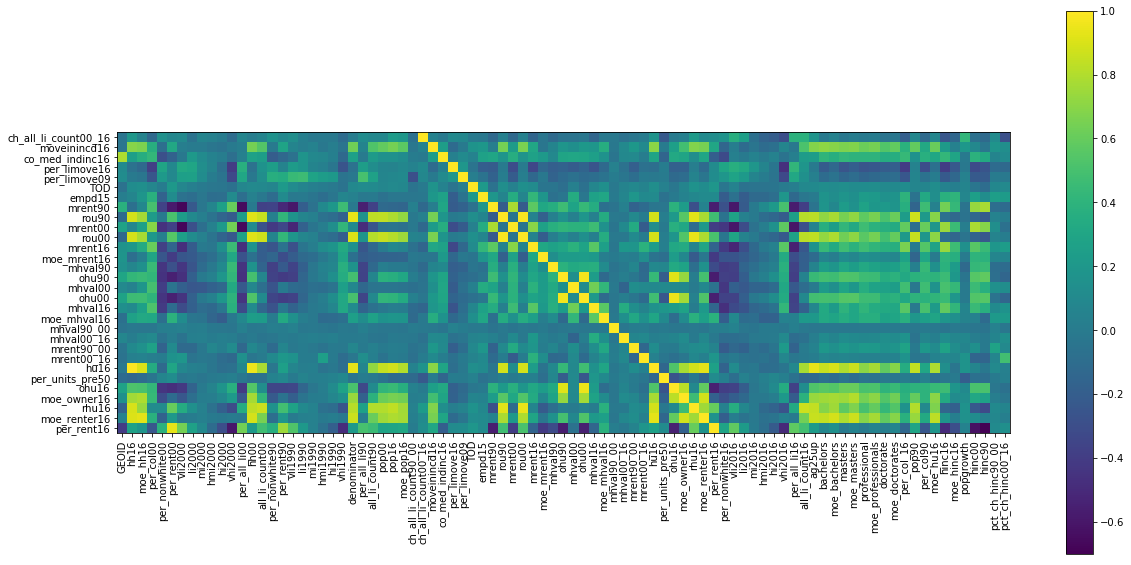

In [158]:
ax = plt.figure(figsize=(20,10)).add_subplot(111)
cax = ax.imshow(corrmatrix_Pearson.iloc[30:60], cmap='viridis')
plt.colorbar(cax)
ax.set_xticks(range(len(corrmatrix_Pearson.columns)))
ax.set_xticklabels(mergedgpd[corrmatrix_Pearson.columns], rotation=90)
ax.set_yticks(range(len(corrmatrix_Pearson.iloc[:,30:60].columns)))
ax.set_yticklabels(corrmatrix_Pearson.iloc[:,30:60].columns);
corrmatrix_Pearson.iloc[:20].columns

In [159]:
# mergedgpd.afford90.isnull().sum()

In [160]:
len(mergedgpd.columns)

90

In [161]:
variables = mergedgpd.drop('geometry', axis=1)

In [162]:
for i,j in enumerate(mergedgpd.columns):
    print(j,i)
    print(type(mergedgpd.loc[1][i]))

GEOID 0
<class 'numpy.int64'>
geometry 1
<class 'shapely.geometry.polygon.Polygon'>
hh16 2
<class 'numpy.float64'>
moe_hh16 3
<class 'numpy.float64'>
per_col00 4
<class 'numpy.float64'>
per_nonwhite00 5
<class 'numpy.float64'>
per_rent00 6
<class 'numpy.float64'>
vli2000 7
<class 'numpy.float64'>
li2000 8
<class 'numpy.float64'>
mi2000 9
<class 'numpy.float64'>
hmi2000 10
<class 'numpy.float64'>
hi2000 11
<class 'numpy.float64'>
vhi2000 12
<class 'numpy.float64'>
per_all_li00 13
<class 'numpy.float64'>
hh00 14
<class 'numpy.float64'>
all_li_count00 15
<class 'numpy.float64'>
per_nonwhite90 16
<class 'numpy.float64'>
per_rent90 17
<class 'numpy.float64'>
vli1990 18
<class 'numpy.float64'>
li1990 19
<class 'numpy.float64'>
mi1990 20
<class 'numpy.float64'>
hmi1990 21
<class 'numpy.float64'>
hi1990 22
<class 'numpy.float64'>
vhi1990 23
<class 'numpy.float64'>
denominator 24
<class 'numpy.float64'>
per_all_li90 25
<class 'numpy.float64'>
all_li_count90 26
<class 'numpy.float64'>
pop00 27
<

In [163]:
print(type(mergedgpd.geometry[1]),mergedgpd.geometry[1])

<class 'shapely.geometry.polygon.Polygon'> POLYGON ((-73.95068000038171 40.81084300040413, -73.95116500026454 40.81017300008393, -73.95166399989371 40.80949000006348, -73.95212499956904 40.80886199988139, -73.95258500009773 40.80823799988377, -73.95291700011951 40.80778000034672, -73.9530400003957 40.80760999970169, -73.95350000002493 40.80698100037289, -73.95395700041524 40.8063530001909, -73.9544159999984 40.80572500000882, -73.95586899955462 40.8063360003062, -73.95726600012576 40.80691600007334, -73.95680599959725 40.80754600034769, -73.95634399987564 40.80817399963041, -73.95588400024643 40.80880199981248, -73.95542999999446 40.80942899994847, -73.95496600018078 40.8100639995539, -73.95357599993245 40.80947700036332, -73.9532769996338 40.80988000006199, -73.95307900039555 40.81009400003813, -73.95259100037435 40.81076500040452, -73.95210100026098 40.81144200014825, -73.95068000038171 40.81084300040413))


# Part 5. Grouping

In [164]:
# Using pre-2016 regressors
cols_before16 = []
for column in variables.columns:
    if '16' not in column:
        cols_before16.append(column)
print(len(cols_before16),cols_before16 )


55 ['GEOID', 'per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'per_nonwhite90', 'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990', 'vhi1990', 'denominator', 'per_all_li90', 'all_li_count90', 'pop00', 'ch_all_li_count90_00', 'per_limove09', 'TOD', 'empd15', 'mrent90', 'rou90', 'mrent00', 'rou00', 'mhval90', 'ohu90', 'mhval00', 'ohu00', 'mhval90_00', 'mrent90_00', 'per_units_pre50', 'ag25up', 'bachelors', 'moe_bachelors', 'masters', 'moe_masters', 'professional', 'moe_professionals', 'doctorate', 'moe_doctorates', 'pop90', 'per_col90', 'popgrowth', 'hinc00', 'hinc90', 'pct_ch_hinc90_00']


In [165]:
variables[cols_before16].head()

,GEOID,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,vhi2000,...,professional,moe_professionals,doctorate,moe_doctorates,pop90,per_col90,popgrowth,hinc00,hinc90,pct_ch_hinc90_00
0,36081113900,0.308353,0.392846,0.588881,0.165321,0.138535,0.059451,0.100951,0.138998,0.396744,...,18.0,21.0,27.0,43.0,3193.000000,0.250109,-117.000000,77528.600000,75677.820392,0.024456
1,36061025700,0.165272,0.955867,0.883148,0.487993,0.198152,0.073064,0.044690,0.072732,0.123368,...,280.0,123.0,161.0,92.0,3241.000000,0.333387,1588.000000,31193.126153,23309.056491,0.338241
2,36047000502,0.779420,0.170020,0.618152,0.119530,0.063569,0.035175,0.065627,0.095087,0.621012,...,389.0,97.0,146.0,82.0,2668.232910,0.291718,-80.943115,94268.847010,76175.578528,0.237521
3,36081015802,0.091283,0.955941,0.451968,0.248304,0.170377,0.082061,0.139400,0.113894,0.245964,...,12.0,18.0,0.0,11.0,4229.585449,0.067395,-46.000000,61377.049024,64278.752779,-0.045143
4,36047116000,0.124260,0.993137,0.651192,0.389734,0.147430,0.087068,0.033895,0.064730,0.277142,...,0.0,11.0,8.0,12.0,1905.000000,0.092979,-446.000000,33757.450000,34416.810000,-0.019158


In [166]:
# Using pre-1990 regressors
cols_before90 = []
for column in variables.columns:
    if '90' in column:
        cols_before90.append(column)
cols_before90 
print(len(cols_before90),cols_before90 )


21 ['per_nonwhite90', 'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990', 'vhi1990', 'per_all_li90', 'all_li_count90', 'ch_all_li_count90_00', 'mrent90', 'rou90', 'mhval90', 'ohu90', 'mhval90_00', 'mrent90_00', 'pop90', 'per_col90', 'hinc90', 'pct_ch_hinc90_00']


In [167]:
variables[cols_before90].head()

,per_nonwhite90,per_rent90,vli1990,li1990,mi1990,hmi1990,hi1990,vhi1990,per_all_li90,all_li_count90,...,mrent90,rou90,mhval90,ohu90,mhval90_00,mrent90_00,pop90,per_col90,hinc90,pct_ch_hinc90_00
0,0.204823,0.548056,0.151913,0.183754,0.056812,0.100683,0.121964,0.384873,0.335667,467.920013,...,636.000003,747.000000,232900.001207,616.000000,-0.010305,0.371069,3193.000000,0.250109,75677.820392,0.024456
1,1.825769,1.789007,1.076692,0.247286,0.159399,0.100824,0.194918,0.220882,1.323978,1594.069214,...,329.308509,1034.000000,136991.523996,118.000000,-0.021966,0.638764,3241.000000,0.333387,23309.056491,0.338241
2,0.071420,0.287210,0.067200,0.035058,0.031725,0.025453,0.047844,0.237797,0.102258,163.299118,...,553.000011,1030.796875,500001.015257,566.582214,-0.564601,0.643761,2668.232910,0.291718,76175.578528,0.237521
3,0.502631,0.252444,0.090191,0.115032,0.070548,0.027556,0.077901,0.178982,0.205223,239.708450,...,676.000009,526.597412,151500.002798,642.000671,0.269967,0.085799,4229.585449,0.067395,64278.752779,-0.045143
4,0.994751,0.839928,0.386384,0.162114,0.122148,0.090324,0.050832,0.188199,0.548498,329.098572,...,444.000000,467.000000,112500.000000,89.000000,0.348444,-0.027027,1905.000000,0.092979,34416.810000,-0.019158


In [168]:
# Using pre-2000 regressors
cols_00 = []
for column in mergedgpd.columns:
    if '00' in column:
        cols_00.append(column)
cols_00 
print(len(cols_00),cols_00 )


26 ['per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'mhval00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']


In [169]:
variables[cols_00].head()

,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,vhi2000,per_all_li00,...,rou00,mhval00,ohu00,mhval90_00,mhval00_16,mrent90_00,mrent00_16,hinc00,pct_ch_hinc90_00,pct_ch_hinc00_16
0,0.308353,0.392846,0.588881,0.165321,0.138535,0.059451,0.100951,0.138998,0.396744,0.303856,...,858.000000,230500.000000,599.000000,-0.010305,1.419523,0.371069,0.772936,77528.600000,0.024456,-0.217644
1,0.165272,0.955867,0.883148,0.487993,0.198152,0.073064,0.044690,0.072732,0.123368,0.686145,...,1111.000000,133982.312925,147.000000,-0.021966,5.173949,0.638764,2.009309,31193.126153,0.338241,1.463107
2,0.779420,0.170020,0.618152,0.119530,0.063569,0.035175,0.065627,0.095087,0.621012,0.183099,...,1024.565796,217699.995305,632.898621,-0.564601,1.251723,0.643761,1.198020,94268.847010,0.237521,0.069335
3,0.091283,0.955941,0.451968,0.248304,0.170377,0.082061,0.139400,0.113894,0.245964,0.418681,...,598.304321,192400.007635,725.471985,0.269967,1.123700,0.085799,0.998638,61377.049024,-0.045143,0.131579
4,0.124260,0.993137,0.651192,0.389734,0.147430,0.087068,0.033895,0.064730,0.277142,0.537164,...,519.000000,151700.000000,278.000000,0.348444,1.257086,-0.027027,0.805556,33757.450000,-0.019158,-0.148336


In [170]:
# Using dowloaded regressors
downloaded_words = ['hh','mrent','medrent','hinc','mhval','medhval','hu','pop','cols_before16']
from_dowonloaded_words_cols = []
for words in downloaded_words:
    for column in mergedgpd.columns:
        if words in column:
            from_dowonloaded_words_cols.append(column)
from_dowonloaded_words_cols

['hh16',
 'moe_hh16',
 'hh00',
 'mrent90',
 'mrent00',
 'mrent16',
 'moe_mrent16',
 'mrent90_00',
 'mrent00_16',
 'hinc16',
 'moe_hinc16',
 'hinc00',
 'hinc90',
 'pct_ch_hinc90_00',
 'pct_ch_hinc00_16',
 'mhval90',
 'mhval00',
 'mhval16',
 'moe_mhval16',
 'mhval90_00',
 'mhval00_16',
 'ohu90',
 'ohu00',
 'hu16',
 'ohu16',
 'rhu16',
 'moe_hu16',
 'pop00',
 'pop16',
 'moe_pop16',
 'pop90',
 'popgrowth']

In [171]:
datadictothers=pd.read_csv('Data/UDP Data Dictionary_Other Variables.csv')
datadictkey=pd.read_csv('Data/UDP Data Dictionary_Key Variables.csv')


In [172]:
datadictkey.rename(columns={"Variable Name Generic": "Field","Input/Created":'Input_Created'},inplace=True)
datadictkey.head()

,Field,Variable Definition,Input_Created,Interpolated
0,*_cv,"""Coefficient of variation for variable""",Created,NaN
1,aboverm_*,"""=1 if above regional median for X""",Created,NaN
2,ag25up*,Denominator for ed attainment,Input,NaN
3,asian*,NH Asian,Input,NaN
4,broad_disp_type,"""Displacement categories with hotmarket""",Created,NaN


In [173]:
datadictothers.rename(columns={"Created variables": "Field"},inplace=True)
datadictothers.head()

,Field,Unnamed: 1,"NOTE: some variables labeled ""intermediate"" are ones created in the code to build variables of interest but should not be used on their own"
0,Name,Description,Not_Used_NY_Update
1,ch_pop_since00,"""Change in pop since 2000""",X
2,pctch_pop_since00,"""Percent change in pop since 2000""",X
3,ch_per_col_since00,"""Change in percent college since 2000""",X
4,pctch_per_col_since00,"""Percent change in percent college since 2000""",X


In [174]:
# remove stars
#remove undersocre
datadictothers['NoStars'] =  datadictothers.Field.str.replace('\*', '')
datadictkey['NoStars'] =  datadictkey.Field.str.replace('\*', '')
datadictothers['NoStars_'] =  datadictothers.NoStars.str.replace('\_', '')
datadictkey['NoStars_'] =  datadictkey.NoStars.str.replace('\_', '')
datadictkey.head()

,Field,Variable Definition,Input_Created,Interpolated,NoStars,NoStars_
0,*_cv,"""Coefficient of variation for variable""",Created,NaN,_cv,cv
1,aboverm_*,"""=1 if above regional median for X""",Created,NaN,aboverm_,aboverm
2,ag25up*,Denominator for ed attainment,Input,NaN,ag25up,ag25up
3,asian*,NH Asian,Input,NaN,asian,asian
4,broad_disp_type,"""Displacement categories with hotmarket""",Created,NaN,broad_disp_type,broaddisptype


In [175]:
datadictkey.NoStars[datadictkey.Input_Created == 'Input'].values

array(['ag25up', 'asian', 'hh', 'hinc', 'hu', 'mhval', 'mrent', 'nhwht',
       'ohu', 'pop', 'rent'], dtype=object)

In [176]:
# possible inptus/created
cols_input1 = datadictkey.NoStars[datadictkey.Input_Created == 'Input'].values
cols_input2 = datadictkey.NoStars_[datadictkey.Input_Created == 'Input'].values
cols_input = list(cols_input1) + list(cols_input2) + from_dowonloaded_words_cols
cols_created1 = datadictkey.NoStars[datadictkey.Input_Created == 'Created'].values
cols_created2 = datadictkey.NoStars_[datadictkey.Input_Created == 'Created'].values
cols_created = list(cols_created1) + list(cols_created2)
print(len(cols_created),cols_created)
print('cols_input ------------------------------\n',len(cols_input),cols_input)

112 ['_cv', 'aboverm_', 'broad_disp_type', 'ch_all_li_count', 'col', 'cv_broad_disp_type', 'cvcat_', 'democh', 'empd', 'excl_li', 'gent1_', 'gent2_', 'vulnrisk', 'hi', 'hmi', 'hotmarket', 'li', 'limig_lessthan', 'lostli', 'mi', 'o_not_burden_li', 'o_not_burden_mhi', 'obnotcomp_li', 'obnotcomp_mhi', 'oburden_li', 'oburden_mhi', 'ohu', 'ototal_li', 'ototal_mhi', 'per_all_li', 'per_col', 'per_incoll', 'per_nonwhite', 'per_rent', 'per_units_pre50', 'popflag', 'popgrowflag', 'ppt_ch_li_movein_since09', 'r_not_burden_li', 'r_not_burden_mhi', 'rbnotcomp_li', 'rbnotcomp_mhi', 'rburden_li', 'rburden_mhi', 'real_hinc', 'real_mhval', 'real_mrent', 'region', 'rhu', 'rm_', 'rtotal_li', 'rtotal_mhi', 'und_disp_flag15', 'vhi', 'vli', 'gentrisk', 'cv', 'aboverm', 'broaddisptype', 'challlicount', 'col', 'cvbroaddisptype', 'cvcat', 'democh', 'empd', 'exclli', 'gent1', 'gent2', 'vulnrisk', 'hi', 'hmi', 'hotmarket', 'li', 'limiglessthan', 'lostli', 'mi', 'onotburdenli', 'onotburdenmhi', 'obnotcompli', 'ob

In [177]:
mergedgpd.columns

Index(['GEOID', 'geometry', 'hh16', 'moe_hh16', 'per_col00', 'per_nonwhite00',
       'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000',
       'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'per_nonwhite90',
       'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990',
       'vhi1990', 'denominator', 'per_all_li90', 'all_li_count90', 'pop00',
       'pop16', 'moe_pop16', 'ch_all_li_count90_00', 'ch_all_li_count00_16',
       'moveinincd16', 'co_med_indinc16', 'per_limove16', 'per_limove09',
       'TOD', 'empd15', 'mrent90', 'rou90', 'mrent00', 'rou00', 'mrent16',
       'moe_mrent16', 'mhval90', 'ohu90', 'mhval00', 'ohu00', 'mhval16',
       'moe_mhval16', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16',
       'hu16', 'per_units_pre50', 'ohu16', 'moe_owner16', 'rhu16',
       'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016',
       'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16',
       'all_li_count16', 'ag25up', '

In [178]:
downloaded_input_created = []
for words in cols_input:
    for column in mergedgpd.columns:
        if words in column:
            downloaded_input_created.append(column)
downloaded_input_created = unique(downloaded_input_created)
print(len(downloaded_input_created),downloaded_input_created)

37 ['ag25up' 'hh00' 'hh16' 'hinc00' 'hinc16' 'hinc90' 'hu16' 'mhval00'
 'mhval00_16' 'mhval16' 'mhval90' 'mhval90_00' 'moe_hh16' 'moe_hinc16'
 'moe_hu16' 'moe_mhval16' 'moe_mrent16' 'moe_pop16' 'moe_renter16'
 'mrent00' 'mrent00_16' 'mrent16' 'mrent90' 'mrent90_00' 'ohu00' 'ohu16'
 'ohu90' 'pct_ch_hinc00_16' 'pct_ch_hinc90_00' 'per_rent00' 'per_rent16'
 'per_rent90' 'pop00' 'pop16' 'pop90' 'popgrowth' 'rhu16']


In [179]:
len(downloaded_input_created)

37

In [180]:
variables[downloaded_input_created].head()

,ag25up,hh00,hh16,hinc00,hinc16,hinc90,hu16,mhval00,mhval00_16,mhval16,...,pct_ch_hinc00_16,pct_ch_hinc90_00,per_rent00,per_rent16,per_rent90,pop00,pop16,pop90,popgrowth,rhu16
0,2591.0,1457.000000,1369.0,77528.600000,60655.0,75677.820392,1448.0,230500.000000,1.419523,557700.0,...,-0.217644,0.024456,0.588881,0.555150,0.548056,3355.000000,3238.0,3193.000000,-117.000000,760.0
1,3214.0,1258.000000,1803.0,31193.126153,76832.0,23309.056491,1984.0,133982.312925,5.173949,827200.0,...,1.463107,0.338241,0.883148,0.670549,1.789007,2923.000000,4511.0,3241.000000,1588.000000,1209.0
2,2188.0,1657.464478,1528.0,94268.847010,100805.0,76175.578528,1672.0,217699.995305,1.251723,490200.0,...,0.069335,0.237521,0.618152,0.664921,0.287210,2698.943115,2618.0,2668.232910,-80.943115,1016.0
3,3543.0,1323.776367,1235.0,61377.049024,69453.0,64278.752779,1284.0,192400.007635,1.123700,408600.0,...,0.131579,-0.045143,0.451968,0.421053,0.252444,4908.000000,4862.0,4229.585449,-46.000000,520.0
4,1396.0,797.000000,896.0,33757.450000,28750.0,34416.810000,984.0,151700.000000,1.257086,342400.0,...,-0.148336,-0.019158,0.651192,0.704241,0.839928,2477.000000,2031.0,1905.000000,-446.000000,631.0


In [181]:
cols_createdpd = pd.DataFrame(cols_created)
cols_createdpd.rename(columns={0:"Field"},inplace=True)
cols_createdpd.Field.head()

0                _cv
1           aboverm_
2    broad_disp_type
3    ch_all_li_count
4                col
Name: Field, dtype: object

In [182]:
cols_createdpd.Field = cols_createdpd.Field.str[:4]
print(len(cols_createdpd.Field.values),cols_createdpd.Field.values)

112 ['_cv' 'abov' 'broa' 'ch_a' 'col' 'cv_b' 'cvca' 'demo' 'empd' 'excl' 'gent'
 'gent' 'vuln' 'hi' 'hmi' 'hotm' 'li' 'limi' 'lost' 'mi' 'o_no' 'o_no'
 'obno' 'obno' 'obur' 'obur' 'ohu' 'otot' 'otot' 'per_' 'per_' 'per_'
 'per_' 'per_' 'per_' 'popf' 'popg' 'ppt_' 'r_no' 'r_no' 'rbno' 'rbno'
 'rbur' 'rbur' 'real' 'real' 'real' 'regi' 'rhu' 'rm_' 'rtot' 'rtot' 'und_'
 'vhi' 'vli' 'gent' 'cv' 'abov' 'broa' 'chal' 'col' 'cvbr' 'cvca' 'demo'
 'empd' 'excl' 'gent' 'gent' 'vuln' 'hi' 'hmi' 'hotm' 'li' 'limi' 'lost'
 'mi' 'onot' 'onot' 'obno' 'obno' 'obur' 'obur' 'ohu' 'otot' 'otot' 'pera'
 'perc' 'peri' 'pern' 'perr' 'peru' 'popf' 'popg' 'pptc' 'rnot' 'rnot'
 'rbno' 'rbno' 'rbur' 'rbur' 'real' 'real' 'real' 'regi' 'rhu' 'rm' 'rtot'
 'rtot' 'undd' 'vhi' 'vli' 'gent']


In [183]:
colstodrop = ['ab','pc','ch']
# cols_created

In [184]:
# Filter out Created Variables From downloaded RAW Regressors

In [185]:
downloaded_input_only = []
for words in downloaded_input_created:
    if words[:2] not in cols_createdpd.Field.values:
            if words[:2] not in colstodrop:
                if words[:5] != 'asian':
                    if words[:5] != 'popgr':
                        downloaded_input_only.append(words)
downloaded_input_only = unique(downloaded_input_only)
print(len(downloaded_input_only),downloaded_input_only)

31 ['ag25up' 'hh00' 'hh16' 'hu16' 'mhval00' 'mhval00_16' 'mhval16' 'mhval90'
 'mhval90_00' 'moe_hh16' 'moe_hinc16' 'moe_hu16' 'moe_mhval16'
 'moe_mrent16' 'moe_pop16' 'moe_renter16' 'mrent00' 'mrent00_16' 'mrent16'
 'mrent90' 'mrent90_00' 'ohu00' 'ohu16' 'ohu90' 'per_rent00' 'per_rent16'
 'per_rent90' 'pop00' 'pop16' 'pop90' 'rhu16']


In [186]:
downloaded_input_only_NO90s = []
for words in downloaded_input_created:
    if '90' in words:
        pass
    elif words[:2] not in cols_createdpd.Field.values:
            if words[:2] not in colstodrop:
                if words[:5] != 'asian':
                    if words[:5] != 'popgr':
                        downloaded_input_only_NO90s.append(words)
downloaded_input_only_NO90s = unique(downloaded_input_only_NO90s)
print(len(downloaded_input_only_NO90s),downloaded_input_only_NO90s)



24 ['ag25up' 'hh00' 'hh16' 'hu16' 'mhval00' 'mhval00_16' 'mhval16' 'moe_hh16'
 'moe_hinc16' 'moe_hu16' 'moe_mhval16' 'moe_mrent16' 'moe_pop16'
 'moe_renter16' 'mrent00' 'mrent00_16' 'mrent16' 'ohu00' 'ohu16'
 'per_rent00' 'per_rent16' 'pop00' 'pop16' 'rhu16']


In [187]:
variables[downloaded_input_only].head(2)

,ag25up,hh00,hh16,hu16,mhval00,mhval00_16,mhval16,mhval90,mhval90_00,moe_hh16,...,ohu00,ohu16,ohu90,per_rent00,per_rent16,per_rent90,pop00,pop16,pop90,rhu16
0,2591.0,1457.0,1369.0,1448.0,230500.000000,1.419523,557700.0,232900.001207,-0.010305,76.0,...,599.0,609.0,616.0,0.588881,0.555150,0.548056,3355.0,3238.0,3193.0,760.0
1,3214.0,1258.0,1803.0,1984.0,133982.312925,5.173949,827200.0,136991.523996,-0.021966,102.0,...,147.0,594.0,118.0,0.883148,0.670549,1.789007,2923.0,4511.0,3241.0,1209.0


In [188]:
final_census_90s =  variables[downloaded_input_only]

In [189]:
final_census = variables[downloaded_input_only_NO90s]

# Clean Resultant Data

In [190]:
final_census_90s= final_census_90s.replace(0,np.nan)


In [191]:
final_census_90s.isnull().sum()

ag25up           36
hh00             39
hh16             44
hu16             43
mhval00          76
mhval00_16       76
mhval16         235
mhval90         339
mhval90_00      346
moe_hh16          0
moe_hinc16       62
moe_hu16          0
moe_mhval16     255
moe_mrent16      77
moe_pop16         0
moe_renter16      0
mrent00          45
mrent00_16       45
mrent16          71
mrent90          45
mrent90_00       51
ohu00            76
ohu16            94
ohu90            91
per_rent00       44
per_rent16       50
per_rent90       45
pop00            32
pop16            36
pop90            30
rhu16            50
dtype: int64

# Part 4. Visualize, Plot against each other

In [192]:
# for i,H in enumerate(final_census.columns):
#     fig = pl.figure(figsize=(5,5))
#     pl.title('Medhval16 vs '+ H)
#     pl.xticks(fontsize=8)
#     pl.yticks(fontsize=8)
#     pl.xlabel(H)
#     pl.ylabel('mhval16')
#     plt.xticks(rotation=70)
#     pl.scatter(variables[H], variables['mhval16'])
#     #ax.plot(schoolsq2[A], schoolsq2[P], label="start")
#     plt.subplots_adjust(hspace=0.5)
#     pl.legend()

In [193]:
# sfig = pd.scatter_matrix(X, s=30, figsize=(10, 10), diagonal='kde')

# Part 5. Clusterize

In [194]:
# Without 90s data


In [195]:
# With 90s data
print(final_census_90s.shape)
final_census_90s= final_census_90s.replace(0,nan)

final_census_90s =final_census_90s.dropna(how='all',axis=0)
print(final_census_90s.shape)
final_census_90s =final_census_90s.dropna(axis=0)
print(final_census_90s.shape)
cols_X = [i for i in final_census.columns if i != 'medval16']


(2164, 31)
(2164, 31)
(1710, 31)


In [225]:
X = np.asarray(final_census_90s[cols_X])
print(X.shape)


y = np.asarray(variables['mhval16'])
y

(1710, 24)


array([  557700.,   827200.,   490200., ...,        0.,   537900.,
        1146400.])

In [226]:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters)
    res=km.fit(X)
    silhouette_avg = silhouette_score(X, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.5391778982325245
For n_clusters = 3, the average silhouette_score is : 0.4781259682742907
For n_clusters = 4, the average silhouette_score is : 0.4219732450928483
For n_clusters = 5, the average silhouette_score is : 0.37925756853614784
For n_clusters = 6, the average silhouette_score is : 0.37236661492650747
For n_clusters = 7, the average silhouette_score is : 0.39545140324574946
For n_clusters = 8, the average silhouette_score is : 0.397220982281508
For n_clusters = 9, the average silhouette_score is : 0.3350757839044258


In [231]:
# X.isnull().sum().sum()

[58321656251729.117, 37888245590040.539, 29932418592103.418, 25552373823421.867, 21677980973861.676, 19089332457747.109, 17252054720040.713, 15892673962035.74, 14594426874598.129, 13521214255622.674, 12676459824062.383, 12056648035292.621, 11541764511291.066, 10891230130967.816, 10650397132264.598, 10147859724544.494, 9708995857809.1992, 9386558291271.5039, 9070122917949.4082, 8770091279801.5273, 8414937300759.4824, 8100594770071.1123, 7891099686601.5859, 7638079904438.3682, 7412361147126.2412, 7288327792437.0938, 7049700265412.0381, 6863017684925.5723, 6691985445476.875, 6426316717583.1191, 6381246994108.583, 6176649725580.5771, 6006113491433.04, 5984685512730.1377, 5629993027907.834, 5539324452146.8809, 5429683505605.1582, 5380842034864.0664, 5330799319593.6758, 5139143224891.4043, 5020174257242.166, 4995878990879.9355, 4898500967119.1475, 4756954199611.8701, 4706134646477.5381, 4664300294651.083, 4561386867522.1533, 4491212444659.8564, 4391779663700.9365, 4338009203045.9287, 4311160

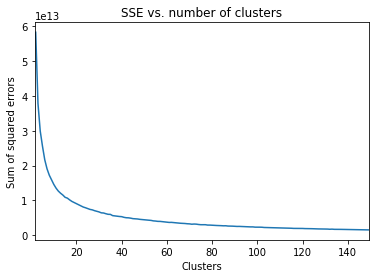

In [232]:
SSE = []
for i in range(2,150):
    km = KMeans(n_clusters = i)
    res=km.fit(X)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,150),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,149.5)
plt.show()

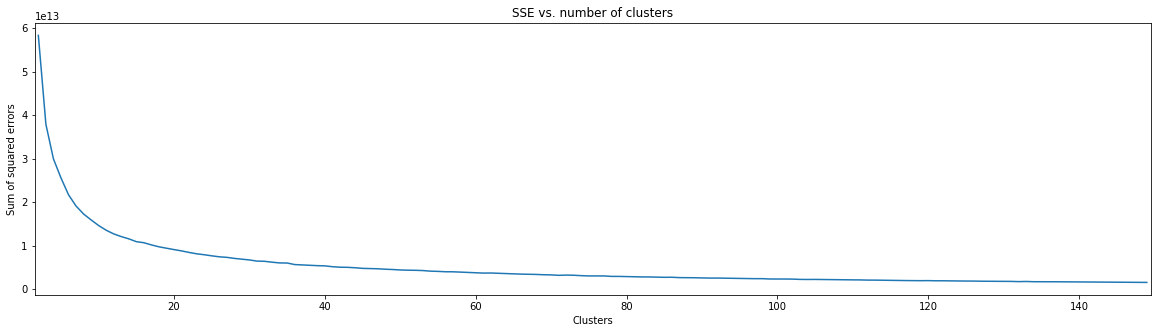

In [233]:
# plt.gca()
plt.figure(figsize=(20,5))

plt.plot(range(2,150),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,149.5)
# plt.xticks(range(150))

plt.show()

In [234]:
n_clusters = 10
km = KMeans(random_state=234,n_clusters=n_clusters)
res=km.fit(X)
y = res.labels_
y
final_census_90s['clusters'] =y
final_census_90s['clusters'].unique()
final_census_90s.to_csv('clusters')

# Part 3. Regressions

In [235]:
# Using only make-sense regressors

In [236]:
# Linear Model

In [237]:
from sklearn import linear_model
lm=linear_model.LinearRegression()
lm.fit(X,y)
1-((lm.predict(X)-y)**2).mean()/y.var()

0.31916754956600801

In [238]:
# Decision Tree

In [239]:
# How well do we do out of sample?  Let's split the data into 60% training, 40% test, and average performance over 10 random splits
from sklearn.model_selection import train_test_split

OS=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)    
    lm=linear_model.LinearRegression()
    lm.fit(X_train,y_train)
    OS.append(1-((lm.predict(X_test)-y_test)**2).mean()/y_test.var()) # or equivalently: OS.append(lm.score(X_test,y_test))
print(np.mean(OS))

0.28935165899


In [269]:
# from sklearn.model_selection import GridSearchCV
# param_grid ={'alpha':np.logspace(-4, 0, 200)}

# OS=[]
# for i in range(10):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)
#     rid=linear_model.Ridge()
#     gr=GridSearchCV(rid,param_grid=param_grid)
#     rs=gr.fit(X_train,y_train)
#     print(rs.best_params_)
#     OS.append(1-((rs.predict(X_test)-y_test)**2).mean()/y_test.var())
# print(np.mean(OS))

In [241]:
## Decision Tree

In [270]:
# from sklearn.tree import DecisionTreeClassifier

# # learn model
# dt=DecisionTreeClassifier()
# dt.fit(X_train,y_train)

# # in sample accuracy
# print('In sample accuracy:',dt.score(X_train,y_train))

# # out of sample accuracy
# print('Out of sample accuracy:',dt.score(X_test,y_test))

In [271]:
OS=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)    
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    OS.append(dt.score(X_test,y_test))
print(np.mean(OS))

0.929434697856


In [273]:
# from sklearn.metrics import roc_auc_score
# AUC_OS=[]
# for i in range(10):
#     X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=i)
#     dt=DecisionTreeClassifier()
#     dt.fit(X_train,y_train)
#     # predict_proba predicts the probability of each class rather than just the most likely class
#     pred=dt.predict(X_test) # predicted probability of y = 1
#     AUC_OS.append(roc_auc_score(np.array(y_test),pred))
# print("OS AUC",np.mean(AUC_OS))

In [274]:
# # How well would we expect to do just by chance?
# chance_OS=[]
# for i in range(10):
#     X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=i)
#     pred=np.random.random(len(X_test))
#     chance_OS.append(roc_auc_score(np.array(y_test.apply(int)),pred))
# print(np.mean(chance_OS))

In [275]:
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

# accuracy = []
# for i in range(1,11):    
#     dt = DecisionTreeClassifier(max_depth=i)
#     dt.fit(X_train, y_train)
#     y_predict = dt.predict(X_test)
#     accuracy.append((y_predict == y_test).value_counts(normalize=True)[True])
# accuracy
# import matplotlib.pylab as plt
# plt.figure(figsize=(7,5))
# plt.plot(range(1,11,1), accuracy, '.-')
# plt.xlabel("Max depth")
# plt.ylabel("accuracy")
# plt.title("Accuracy vs Simplicity (max depth)")
# plt.xlim(1,10)
# plt.grid(True)
# plt.show()

In [276]:
# from sklearn.model_selection import GridSearchCV
# param_grid ={'max_depth':range(1,11)}
# dt = DecisionTreeClassifier()
# gr=GridSearchCV(dt,param_grid=param_grid)
# rs=gr.fit(X_train,y_train)
# print 'Best parameter value:',rs.best_params_
# y_predict = rs.predict(X_test)
# print 'Accuracy = ',((y_predict == y_test).value_counts(normalize=True)[True])

In [277]:
# Random Forest

In [278]:
from sklearn.ensemble  import RandomForestRegressor as rfr


In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Supervised transformation based on random forests
rf = rfr(max_depth=3, n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [261]:
y_pred = rf.predict(X_test)
y_pred
rf.score(X_train, y_train)

0.78001230373149866

In [263]:
R2_train=[]
R2_test=[]
for i in range(50):
    np.random.seed(2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    rf = rfr(max_depth=3, n_estimators=100, random_state=1)
    rf.fit(X_train, y_train)
    rf = rfr(max_depth=3, n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    R2_train.append(rf.score(X_train, y_train))
    R2_test.append(rf.score(X_test, y_test))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))
#print("R2_train:",R2_train,"\n R2_test",R2_test)

R2_train: 0.774990579309 
 R2_test 0.757975903153


In [266]:
zx_1 = skl.mean_squared_error(y_test, y_pred)
zx_1

1.1218641679432568

In [267]:
R2_train=[]
R2_test=[]
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rf = rfr(max_depth=3, n_estimators=100)
    rf.fit(X_train, y_train)
    rf = rfr(max_depth=3, n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    R2_train.append(rf.score(X_train, y_train))
    R2_test.append(rf.score(X_test, y_test))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))
#print("R2_train:",R2_train,"\n R2_test",R2_test)

R2_train: 0.777716327346 
 R2_test 0.737637702894


In [268]:
zx_1 = skl.mean_squared_error(y_test, y_pred)
zx_1

1.2319936833382581

In [ ]:
#### Comments on results: **the model is overfitting if it performs far better on the training set than on the test set**
#### To improve, we will prepare the data better by scaling

In [ ]:
### 10.1.1 Standarize the features